<a href="https://colab.research.google.com/github/benmsanderson/tcre-star/blob/main/tcre_star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get forest definition data (if not present)

Import stuff

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
readdata=0
datadir='/content/drive/MyDrive/grassi'

In [ ]:
from sklearn.linear_model import LinearRegression

import numpy as np

In [ ]:
!pip install fair==1.6.4

import fair as fair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 3.8 MB/s eta 0:00:00


In [ ]:
from fair.SSPs import ssp119, ssp126, ssp245, ssp370, ssp585, ssp534
import pandas as pd

In [ ]:
emms=pd.DataFrame()

emms['ssp119']=ssp119.Emissions.co2_fossil
emms['ssp126']=ssp126.Emissions.co2_fossil
emms['ssp245']=ssp245.Emissions.co2_fossil
emms['ssp370']=ssp370.Emissions.co2_fossil
emms['ssp534']=ssp534.Emissions.co2_fossil
emms['ssp585']=ssp585.Emissions.co2_fossil
emms.index=ssp585.Emissions.year
emms.to_excel("/content/drive/MyDrive/sspfos.xlsx",
             sheet_name='emissions')

In [ ]:

#os.environ["ESMFMKFILE"] = "/uio/kant/div-cicero-u1/bensan/.conda/envs/xesmf/lib/esmf.mk"

In [ ]:
!pip install cftime
!pip install geopandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00


In [ ]:
!pip install geocube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
from geocube.api.core import make_geocube
import geopandas as gpd


In [ ]:

#import xesmf as xe
from shapely.geometry import LineString
from shapely.ops import split
from shapely.affinity import translate
#import rasterio
#import rioxarray
#from shapely.geometry import mapping

import pandas as pd
#import zarr
import xarray as xr
import matplotlib.pyplot as plt
import dask
import requests
import xml.etree.ElementTree as ET
#
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [ ]:
def make_weights(out_grid,out_fgrid,ds):
  upsampled = out_grid.interp_like(ds)
  upsampled['intfrac']=upsampled['exists'].fillna(0)
  upsampled_f = out_fgrid.interp_like(ds)
  upsampled['allfrac']=upsampled_f['exists'].fillna(0)
  upsampled['distfrac']=upsampled['allfrac']-upsampled['intfrac']
  return upsampled

In [ ]:
def glb_mn(dy,fld):
  #dy
  weights = np.cos(np.deg2rad(dy.lat))
  weights=weights/np.mean(weights)
  weights.name = "weights"
  glb_ttl=dy[fld].mean("lon",skipna=True).weighted(weights).mean("lat",skipna=True)#*area_earth
  return glb_ttl
  #glb_dis=dy['cLand_dist_d'].mean("lon").weighted(weights).mean("lat")*area_earth*1e-12

In [ ]:
def get_gflx(dy,co2_atm):
  area_earth=5.1e14
  kg_to_Pg=1e-12
  glb_ttl=glb_mn(dy,'cLand').values*area_earth*kg_to_Pg
  glb_ttl=glb_ttl-glb_ttl[0]
  glb_dis=glb_mn(dy,'cLand_dist').values*area_earth*kg_to_Pg
  glb_dis=glb_dis-glb_dis[0]
  ocn_ttl=glb_mn(dy,'cOcn_d').values*area_earth*kg_to_Pg
  ocn_ttl=ocn_ttl-ocn_ttl[0]
  try:
      prd_ttl=glb_mn(dy,'cProduct').values*area_earth*kg_to_Pg
  except:
      prd_ttl=glb_ttl*np.NaN
  try:
      hrv_ttl=glb_mn(dy,'fHarvest').values*area_earth*kg_to_Pg
  except:
      hrv_ttl=glb_ttl*np.NaN
  try:
      lit_ttl=glb_mn(dy,'cLitter').values*area_earth*kg_to_Pg
  except:
      lit_ttl=glb_ttl*np.NaN
  #co2_atm=278*1.01**np.arange(0,len(dy['year']))
  atm_ttl=(co2_atm-co2_atm[0])*2.12
  tas=glb_mn(dy,'tas').values
  return glb_ttl,glb_dis,ocn_ttl,atm_ttl,tas,prd_ttl,hrv_ttl,lit_ttl

In [ ]:
def get_tcre(cumemis,tas):
  reg = LinearRegression().fit(cumemis[:70].reshape(-1, 1)/1000, tas[:70])
  tcre=reg.coef_
  pit=reg.intercept_
  return (tcre,pit)

In [ ]:
flds=['cVeg','cSoil','cLitter','fgco2','tas']

In [ ]:
mdls=['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CESM2', 'CESM2-WACCM',
       'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'GFDL-ESM4',
       'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0','NorESM2-MM']
ofrc=np.ones(len(mdls))
ofrc[1]=-1/1000
ofrc[2]=-1/1000
mdlfilt=mdls


In [ ]:
dy=[]
for i,m in enumerate(mdls):
    dy.append(xr.open_dataset(datadir+'/'+m+'_1pct.nc'))

In [ ]:
glb_ttl= np.empty((250,len(mdlfilt)))
glb_dis= np.empty((250,len(mdlfilt)))
ocn_ttl= np.empty((250,len(mdlfilt)))
atm_ttl= np.empty((250,len(mdlfilt)))
prd_ttl= np.empty((250,len(mdlfilt)))

tas= np.empty((250,len(mdlfilt)))

for i,m in enumerate(mdlfilt):
    print(i)
    co2atm=278*1.01**np.arange(0,len(dy[i]['year']))
    (glb_ttl_tmp,glb_dis_tmp,ocn_ttl_tmp,atm_ttl_tmp,tas_tmp,prd_tmp,hrv_tmp,lit_tmp)=get_gflx(dy[i],co2atm)
    glb_ttl[:len(glb_ttl_tmp),i]=glb_ttl_tmp
    glb_dis[:len(glb_ttl_tmp),i]=glb_dis_tmp
    ocn_ttl[:len(glb_ttl_tmp),i]=ocn_ttl_tmp
    atm_ttl[:len(glb_ttl_tmp),i]=atm_ttl_tmp
    prd_ttl[:len(glb_ttl_tmp),i]=prd_tmp

    tas[:len(glb_ttl_tmp),i]=tas_tmp


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


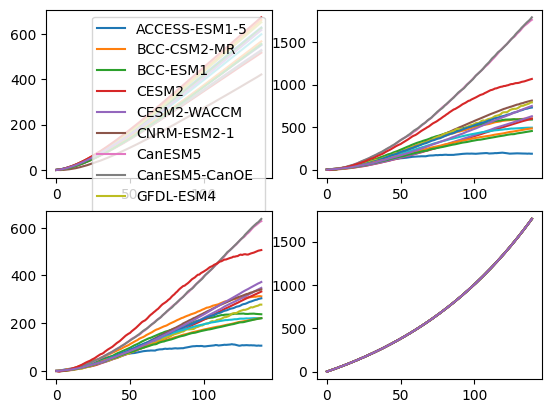

In [ ]:
fig, axs = plt.subplots(2, 2)
axs=axs.flatten()

p1=axs[0].plot(ocn_ttl[:140,:])
axs[1].plot(glb_ttl[:140,:])

axs[2].plot(glb_dis[:140,:])
axs[3].plot(atm_ttl[:140,:])
axs[0].legend(p1,mdlfilt)

In [ ]:
cumemis=atm_ttl+glb_ttl+ocn_ttl
cumemis_unfccc=atm_ttl+glb_ttl+ocn_ttl-glb_dis




In [ ]:
pi_t=[]
tcre=[]
tcre_un=[]
for i,m in enumerate(mdlfilt):
        try:
         (tcretmp,pit)=get_tcre(cumemis[:70,i],tas[:70,i])
         (tcre_untmp,pit)=get_tcre(cumemis_unfccc[:70,i],tas[:70,i])
        except:
         tcretmp=np.NaN
         tcre_untmp=np.NaN
         pit=np.NaN
        pi_t.append(pit)
        tcre.append(tcretmp)
        tcre_un.append(tcre_untmp)


In [ ]:
tcre=np.hstack(tcre)
tcre_un=np.hstack(tcre_un)


In [ ]:
pit

287.0084442908116

1

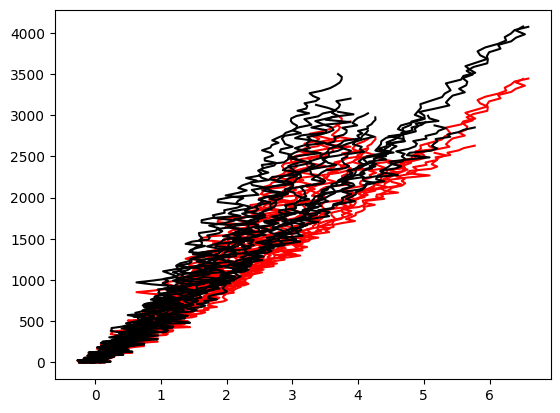

In [ ]:
plt.plot(tas[:140,:]-pi_t,cumemis_unfccc[:140,:],'r')
plt.plot(tas[:140,:]-pi_t,cumemis[:140,:],'k')
1

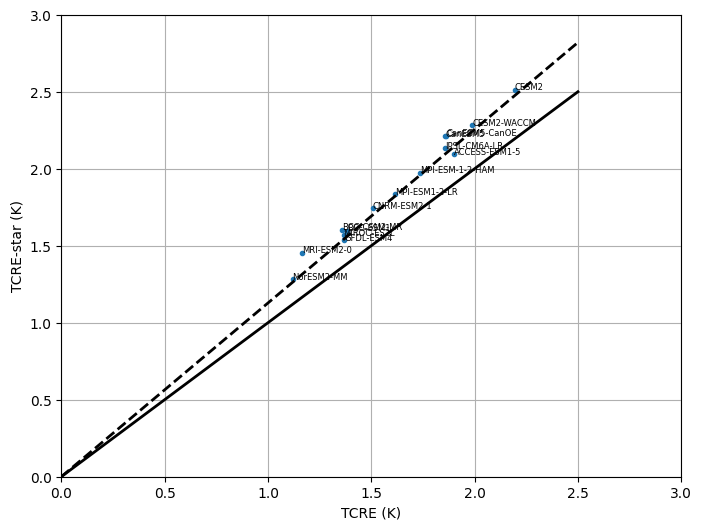

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(tcre,tcre_un,'.')
plt.plot([0,2.5],[0,2.5],'k-')
plt.plot([0,2.5],[0,2.82],'k--')
for i,m in enumerate(mdls):
  plt.text(tcre[i],tcre_un[i],m,fontsize=6)


plt.xlim([0,3])
plt.ylim([0,3])
plt.xlabel('TCRE (K)')
plt.ylabel('TCRE-star (K)')
plt.grid()

In [ ]:
2.82/2.5

1.128

!Scenarios


In [ ]:
mdl26=['CESM2',  'GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR']
oscns=['historical','ssp126','ssp245','ssp585']


In [ ]:
scns=['ssp126','ssp245','ssp585']


In [ ]:
#READ concentrations

!wget  -nc https://greenhousegases.science.unimelb.edu.au/data/future/CMIP6GHGConcentrationProjections_1_2_1/mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc
!wget  -nc https://greenhousegases.science.unimelb.edu.au/data/historical/CMIP6GHGConcentrationHistorical_1_2_0/mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc
!wget  -nc https://greenhousegases.science.unimelb.edu.au/data/future/CMIP6GHGConcentrationProjections_1_2_1/mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc
!wget  -nc https://greenhousegases.science.unimelb.edu.au/data/future/CMIP6GHGConcentrationProjections_1_2_1/mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_2015-2500.nc

db26=xr.open_dataset('mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc',decode_times=False)
dbhist=xr.open_dataset('mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc',decode_times=False)
db85=xr.open_dataset('mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc',decode_times=False)
db45=xr.open_dataset('mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_2015-2500.nc',decode_times=False)

dbconc=xr.concat((dbhist,db26),'time')
dbconc85=xr.concat((dbhist,db85),'time')
dbconc45=xr.concat((dbhist,db45),'time')




ppm26=dbconc['mole_fraction_of_carbon_dioxide_in_air'][1850:2350,1].values
ppm85=dbconc85['mole_fraction_of_carbon_dioxide_in_air'][1850:2350,1].values
ppm45=dbconc45['mole_fraction_of_carbon_dioxide_in_air'][1850:2350,1].values

atm_ttl=np.zeros([len(ppm26),len(mdl26),len(scns)])
atm_ttl[:,:,0]=np.repeat((ppm26-ppm26[0])[:,np.newaxis]*2.12,len(mdl26),axis=1)
atm_ttl[:,:,1]=np.repeat((ppm45-ppm45[0])[:,np.newaxis]*2.12,len(mdl26),axis=1)
atm_ttl[:,:,2]=np.repeat((ppm85-ppm45[0])[:,np.newaxis]*2.12,len(mdl26),axis=1)



File ‘mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc’ already there; not retrieving.

File ‘mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc’ already there; not retrieving.

File ‘mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc’ already there; not retrieving.

File ‘mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_2015-2500.nc’ already there; not retrieving.



In [ ]:
readdata=0

In [ ]:
ds={}
for s in oscns:
    ds[s]=[]
    for i,m in enumerate(mdl26):
        ds[s].append(xr.open_dataset(datadir+'/'+m+'_'+s+'.nc'))


In [ ]:
i=mdl26.index("GFDL-ESM4")
for s in oscns:
    ds[s][i]['cLand']=ds[s][i]['cSlVg']
    ds[s][i]['cLand_dist']=ds[s][i]['cSlVg_dist']


In [ ]:
mdl26

['CESM2', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR']

In [ ]:
i=mdl26.index("IPSL-CM6A-LR")
for s in scns:
    ds[s][i]['cLand'][0,:,:]=ds[s][i]['cLand'][1,:,:]
    ds[s][i]['cLand_dist'][0,:,:]=ds[s][i]['cLand_dist'][1,:,:]


In [ ]:
dy_conc={}
for s in scns:
    print(s)
    dy_conc[s]=[]
    for i,m in enumerate(mdl26):
        print(m)
        dy_conc[s].append(xr.concat((ds['historical'][i],ds[s][i]),'year'))

ssp126
CESM2
GFDL-ESM4
IPSL-CM6A-LR
MPI-ESM1-2-LR
ssp245
CESM2
GFDL-ESM4
IPSL-CM6A-LR
MPI-ESM1-2-LR
ssp585
CESM2
GFDL-ESM4
IPSL-CM6A-LR
MPI-ESM1-2-LR


In [ ]:
for s in scns:
    for i,m in enumerate(mdl26):
        tmp=dy_conc[s][i]
        dy_conc[s][i]['cOcn_d']=tmp['fgco2'].cumsum(dim='year')*3600*24*365




In [ ]:
glb_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
glb_dis= np.ones((500,len(mdl26),len(scns)))*np.nan
ocn_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
#atm_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
prd_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
hrv_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
lit_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
prd_dis= np.ones((500,len(mdl26),len(scns)))*np.nan

tas_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
for j,s in enumerate(scns):
    for i,m in enumerate(mdl26):
        co2atm=278*1.01**np.arange(0,len(dy_conc[s][i]['year']))
        (glb_ttl_tmp,glb_dis_tmp,ocn_ttl_tmp,atm_ttl_tmp,tas_tmp,prd_tmp,hrv_tmp,lit_tmp)=get_gflx(dy_conc[s][i],co2atm)
        glb_ttl[:len(glb_ttl_tmp),i,j]=glb_ttl_tmp
        glb_dis[:len(glb_ttl_tmp),i,j]=glb_dis_tmp
        ocn_ttl[:len(glb_ttl_tmp),i,j]=ocn_ttl_tmp
#        atm_ttl[:len(glb_ttl_tmp),i,j]=atm_ttl_tmp
        prd_ttl[:len(glb_ttl_tmp),i,j]=prd_tmp
        hrv_ttl[:len(glb_ttl_tmp),i,j]=hrv_tmp
        lit_ttl[:len(glb_ttl_tmp),i,j]=lit_tmp
        tas_ttl[:len(glb_ttl_tmp),i,j]=tas_tmp


In [ ]:
i=mdl26.index("GFDL-ESM4")
prd_ttl[:,i,1:]=np.NaN
prd_dis[:,i,1:]=np.NaN


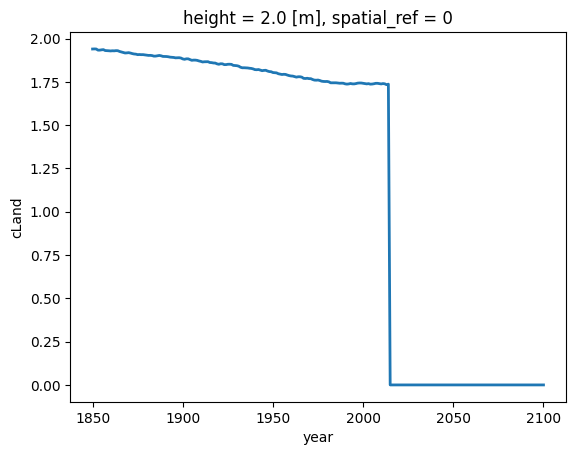

In [ ]:
dy_conc['ssp245'][1].cLand.mean('lat').mean('lon').plot()

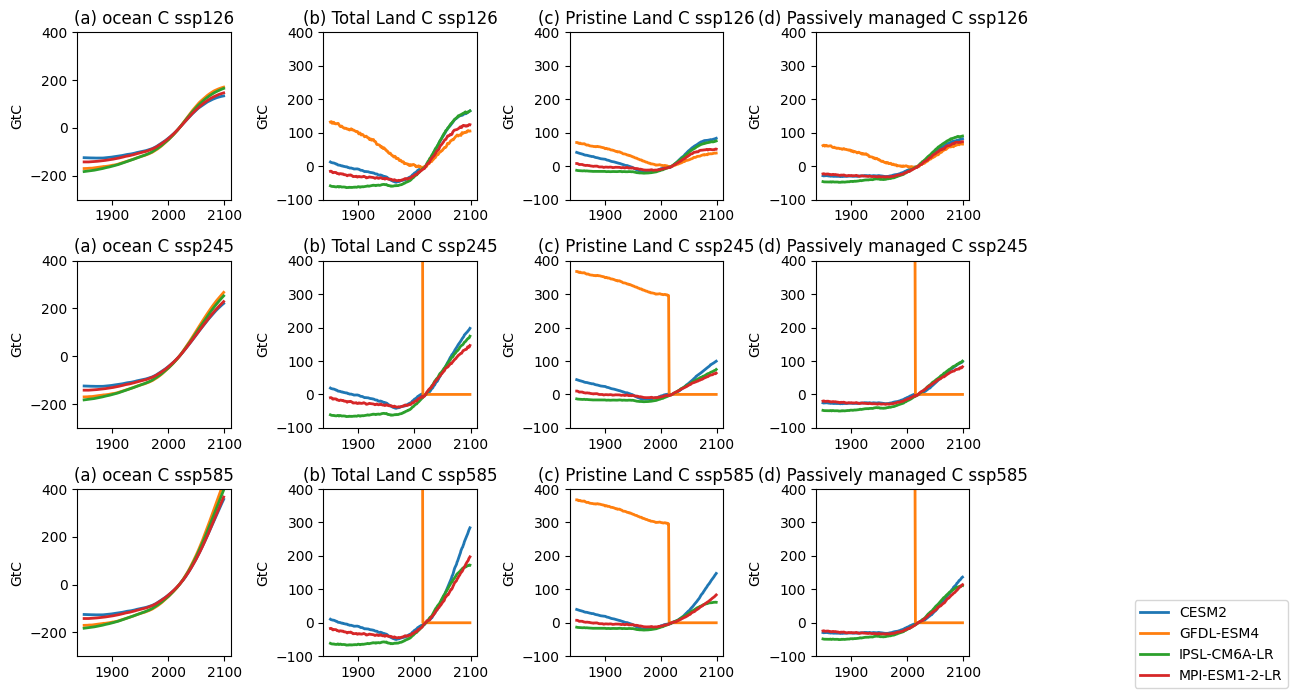

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(10, 7))
#axs=axs.flatten()
yrs=np.arange(1850,2100)
bsyr=np.where(yrs == 2020)[0][0]
for i,s in enumerate(scns):
    p1=axs[i,0].plot(yrs,ocn_ttl[:250,:,i]-ocn_ttl[bsyr,:,i])
    axs[i,0].set_title('(a) ocean C '+s)

    axs[i,0].set_ylabel('GtC')
    axs[i,0].set_ylim([-300,400])


    axs[i,1].plot(yrs,glb_ttl[:250,:,i]-glb_ttl[bsyr,:,i])
    axs[i,1].set_title('(b) Total Land C '+s)
    axs[i,1].set_ylabel('GtC')
    axs[i,1].set_ylim([-100,400])


    axs[i,2].plot(yrs,glb_dis[:250,:,i]-glb_dis[bsyr,:,i])
    axs[i,2].set_title('(c) Pristine Land C '+s)
    axs[i,2].set_ylabel('GtC')
    axs[i,2].set_ylim([-100,400])

    axs[i,3].plot(yrs,glb_ttl[:250,:,i]-glb_ttl[bsyr,:,i]-(glb_dis[:250,:,i]-glb_dis[bsyr,:,i]))
    axs[i,3].set_title('(d) Passively managed C '+s)
    axs[i,3].set_ylabel('GtC')
    axs[i,3].set_ylim([-100,400])
    #axs[3].plot(yrs,atm_ttl26[:250,:])
lg=fig.legend(p1,mdl26, bbox_to_anchor=(1.3, 0),loc = 'lower right')
plt.tight_layout()

In [ ]:

cumemis=atm_ttl+glb_ttl+ocn_ttl
cumemis_unfccc=atm_ttl+glb_ttl+ocn_ttl-glb_dis

cumemis.shape

(500, 4, 3)

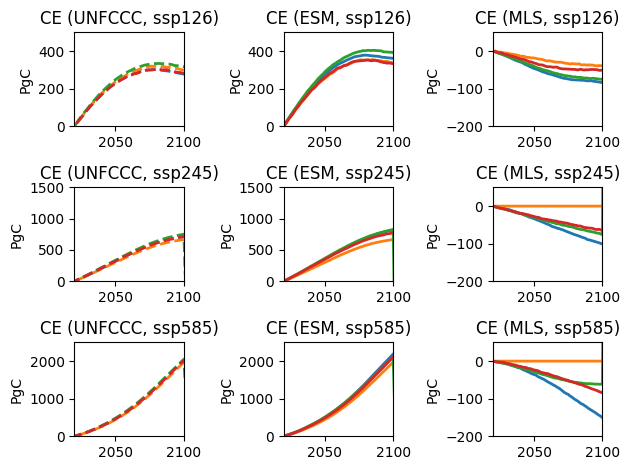

In [ ]:
fig, axs = plt.subplots(3,3)
#axs=axs.flatten()

ext=[0,1000,2000]
for i,s in enumerate(scns):
    p1=axs[i,0].plot(np.arange(1850,2350),cumemis_unfccc[:,:,i]-cumemis_unfccc[170,:,i],'--')
    axs[i,0].set_xlim([2020,2100])
    axs[i,0].set_ylim([0,500+ext[i]])
    axs[i,0].set_title('CE (UNFCCC, '+s+')')
    axs[i,0].set_ylabel('PgC')

    axs[i,1].plot(np.arange(1850,2350),cumemis[:,:,i]-cumemis[170,:,i],'-')
    axs[i,1].set_xlim([2020,2100])
    axs[i,1].set_ylim([0,500+ext[i]])
    axs[i,1].set_title('CE (ESM, '+s+')')
    axs[i,1].set_ylabel('PgC')
    tmp=(cumemis_unfccc[:,:,i]-cumemis[:,:,i])
    axs[i,2].plot(np.arange(1850,2350),tmp-tmp[170,:],'-')
    axs[i,2].set_xlim([2020,2100])
    axs[i,2].set_ylim([-200,50])
    axs[i,2].set_title('CE (MLS, '+s+')')
    axs[i,2].set_ylabel('PgC')



plt.tight_layout()


In [ ]:
fryr=ssp126.Emissions.emissions[:,0]

In [ ]:
tmp=ssp126.Emissions.emissions[86:335,1]
fos=np.zeros((len(tmp),len(scns)))
lu=np.zeros((len(tmp),len(scns)))

fos[:,0]=ssp126.Emissions.emissions[86:335,1]
lu[:,0]=ssp126.Emissions.emissions[86:335,2]
fos[:,1]=ssp245.Emissions.emissions[86:335,1]
lu[:,1]=ssp245.Emissions.emissions[86:335,2]
fos[:,2]=ssp585.Emissions.emissions[86:335,1]
lu[:,2]=ssp585.Emissions.emissions[86:335,2]

cumemis is only fossil - as a residual

land flux (glb_ttl) is LU+MANAGED


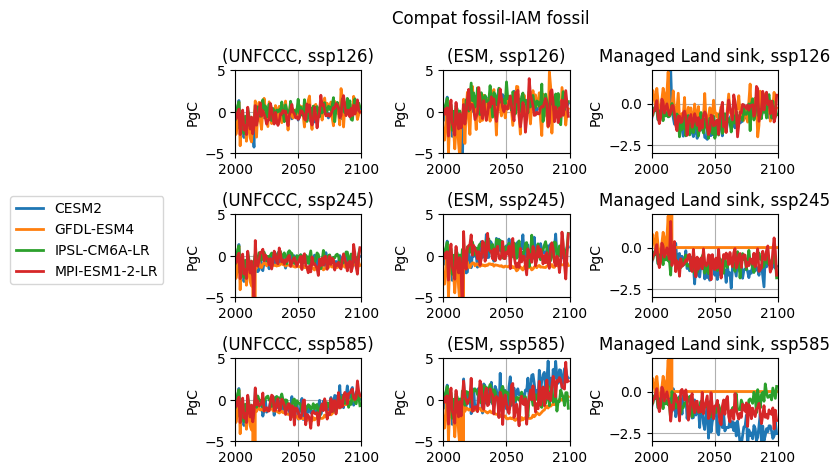

In [ ]:
fig, axs = plt.subplots(3,3)
#axs=axs.flatten()

#axs[0,0].plot(np.arange(1851,2100),lu26,'k--')
for i,s in enumerate(scns):
    p1=axs[i,0].plot(np.arange(1851,2100),np.diff(cumemis_unfccc[:250,:,i],axis=0)-np.tile(fos[:,i],(4,1)).T,'-',label=mdl26)
    axs[i,0].set_xlim([2000,2100])
    axs[i,0].set_ylim([-5,5])
    axs[i,0].set_title('(UNFCCC, '+s+')')
    axs[i,0].set_ylabel('PgC')
    axs[i,0].grid()
    #axs[0,0].legend()

    axs[i,1].plot(np.arange(1851,2100),np.diff(cumemis[:250,:,i],axis=0)-np.tile(fos[:,i],(4,1)).T,'-')
    axs[i,1].set_xlim([2000,2100])
    axs[i,1].set_ylim([-5,5])
    axs[i,1].set_title('(ESM, '+s+')')
    axs[i,1].set_ylabel('PgC')
    axs[i,1].grid()

    tmp=(cumemis_unfccc[:,:,i]-cumemis[:,:,i])
    axs[i,2].plot(np.arange(1851,2100),np.diff(tmp[:250,:],axis=0),'-')
    axs[i,2].set_xlim([2000,2100])
    axs[i,2].set_ylim([0-3,2])
    axs[i,2].set_title('Managed Land sink, '+s+'')
    axs[i,2].set_ylabel('PgC')
    axs[i,2].grid()

fig.suptitle('Compat fossil-IAM fossil')
plt.tight_layout()

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0, 0.5))

In [ ]:
mdl26

['CESM2', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR']

In [ ]:
cumemis.shape

(500, 4, 3)

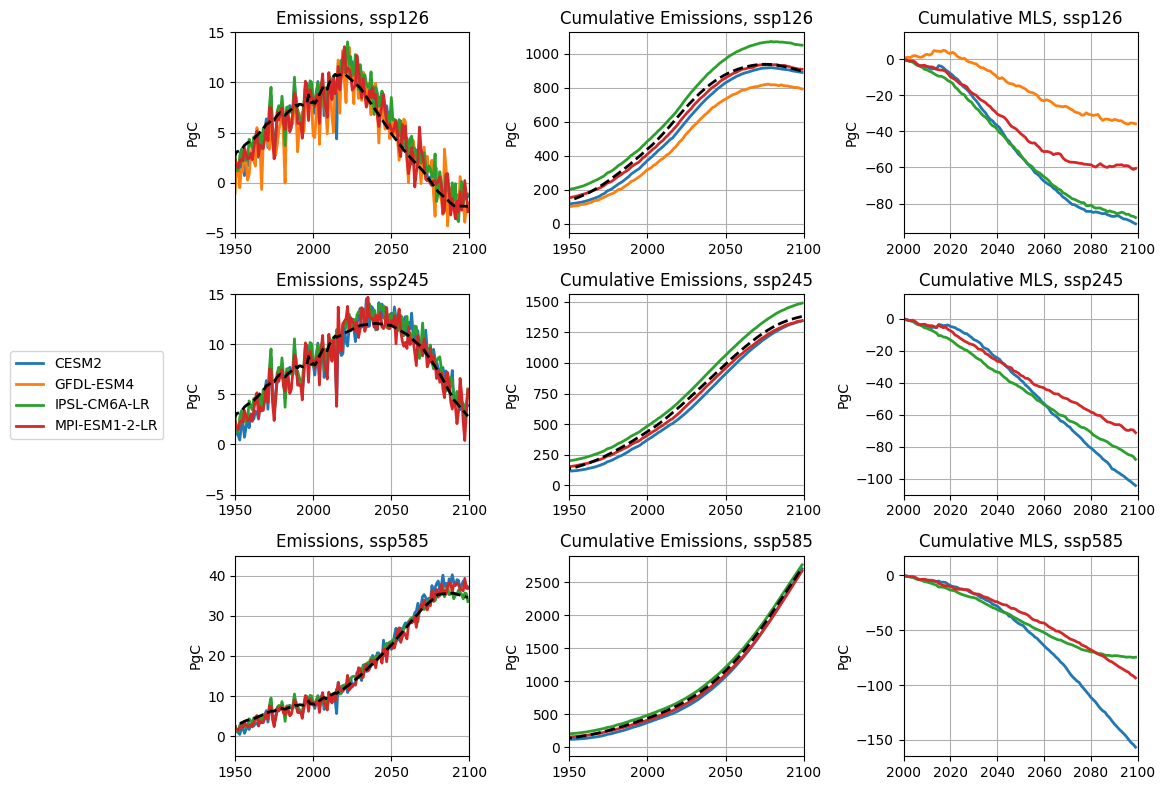

In [ ]:
fig, axs = plt.subplots(3,3,figsize=[10,8])
#axs=axs.flatten()
cumemis[:,1,1]=np.NaN
cumemis[:,1,2]=np.NaN

#axs[0,0].plot(np.arange(1851,2100),lu26,'k--')
for i,s in enumerate(scns):
    p1=axs[i,1].plot(np.arange(1851,2100),cumemis[:249,:,i]+np.cumsum(lu[:,i])[:, np.newaxis],'-',label=mdl26)
    axs[i,1].plot(np.arange(1851,2100),np.cumsum(fos[:,i]+lu[:,i]),'k--')

    axs[i,1].set_xlim([1950,2100])
    axs[i,1].set_title('Cumulative Emissions, '+s+'')
    axs[i,1].set_ylabel('PgC')
    axs[i,1].grid()
    #axs[0,0].legend()

    axs[i,0].plot(np.arange(1851,2100),np.diff(cumemis[:250,:,i],axis=0)+lu[:,i][:, np.newaxis],'-')
    axs[i,0].plot(np.arange(1851,2100),fos[:,i]+lu[:,i],'k--')
    axs[i,0].set_xlim([1950,2100])
    axs[i,0].set_ylim([-5,30])
    axs[i,0].set_title('Emissions, '+s+'')
    axs[i,0].set_ylabel('PgC')
    axs[i,0].grid()

    tmp=(cumemis_unfccc[:,:,i]-cumemis[:,:,i])
    axs[i,2].plot(np.arange(1850,2100),tmp[:250,:]-tmp[150,:],'-')
    axs[i,2].set_xlim([2000,2100])
    #axs[i,2].set_ylim([0-3,2])
    axs[i,2].set_title('Cumulative MLS, '+s+'')
    axs[i,2].set_ylabel('PgC')
    axs[i,2].grid()

axs[0,0].set_ylim([-5,15])
axs[1,0].set_ylim([-5,15])
axs[2,0].set_ylim([-5,45])



plt.tight_layout()
handles, labels = axs[0,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0, 0.5))

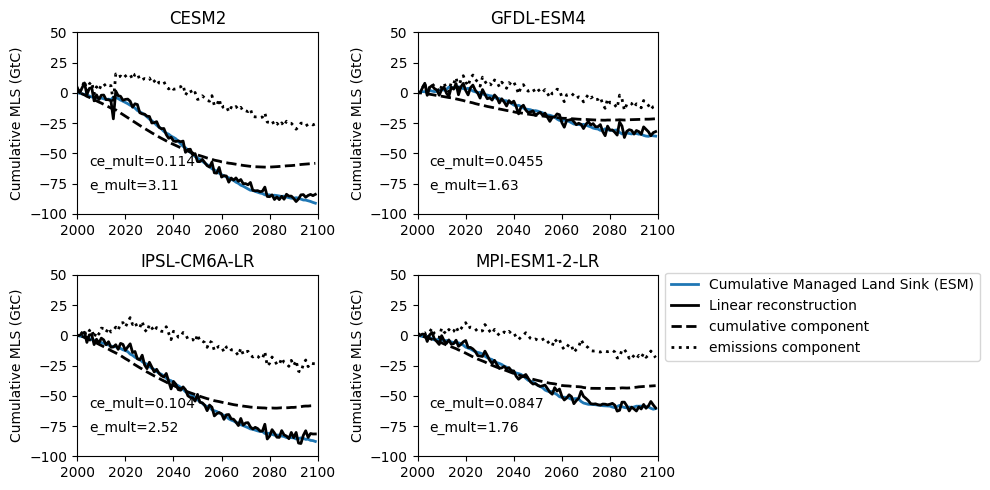

In [ ]:

from sklearn import linear_model



regr = linear_model.LinearRegression(fit_intercept=False)


fig, axs = plt.subplots(2,2,figsize=[10,5])
axs=axs.flatten()
for i in np.arange(0,4):
  recon_c=-(cumemis[:249,i,0]+np.cumsum(lu[:,0]))
  recon_e=(np.diff(cumemis[:250,i,0],axis=0)+lu[:,0])
  recon_c=recon_c-recon_c[150]
  recon_e=recon_e-recon_e[150]

  recon=recon_c+recon_e

  tmp=(cumemis_unfccc[:,i,0]-cumemis[:,i,0])
  axs[i].plot(np.arange(1850,2100),tmp[:250]-tmp[150],'-',label='Cumulative Managed Land Sink (ESM)')
  regr.fit(np.vstack([recon_c,recon_e]).T[150:,:], tmp[150:249]-tmp[150])


  predictedCO2 = regr.predict(np.vstack([recon_c,recon_e]).T)
  axs[i].set_xlim(2000,2100)
  axs[i].set_ylim(-100,50)

  axs[i].plot(np.arange(1851,2100), predictedCO2,'k-',label='Linear reconstruction')

  axs[i].plot(np.arange(1851,2100),recon_c*regr.coef_[0],'k--',label='cumulative component')
  axs[i].plot(np.arange(1851,2100),recon_e*regr.coef_[1],'k:',label='emissions component')
  axs[i].set_title(mdl26[i])

  axs[i].text(2005,-60,'ce_mult='+str(float('%.3g' % regr.coef_[0])))
  axs[i].text(2005,-80,'e_mult='+str(float('%.3g' % regr.coef_[1])))
  axs[i].set_ylabel('Cumulative MLS (GtC)')
axs[i].legend(bbox_to_anchor=(1.0, 1.05))
plt.tight_layout()

In [ ]:
regr.coef_

array([0.08467142, 1.75648048])

In [ ]:
f_in=[mdls.index(m) for m in mdl26]

In [ ]:
tcre[f_in]

array([2.19426033, 1.36940687, 1.85872756, 1.61505979])

In [ ]:
tcre_un[f_in]

array([2.51365088, 1.53787705, 2.13558729, 1.8351387 ])

test cumulative emissions prediction of warming (tcre*)

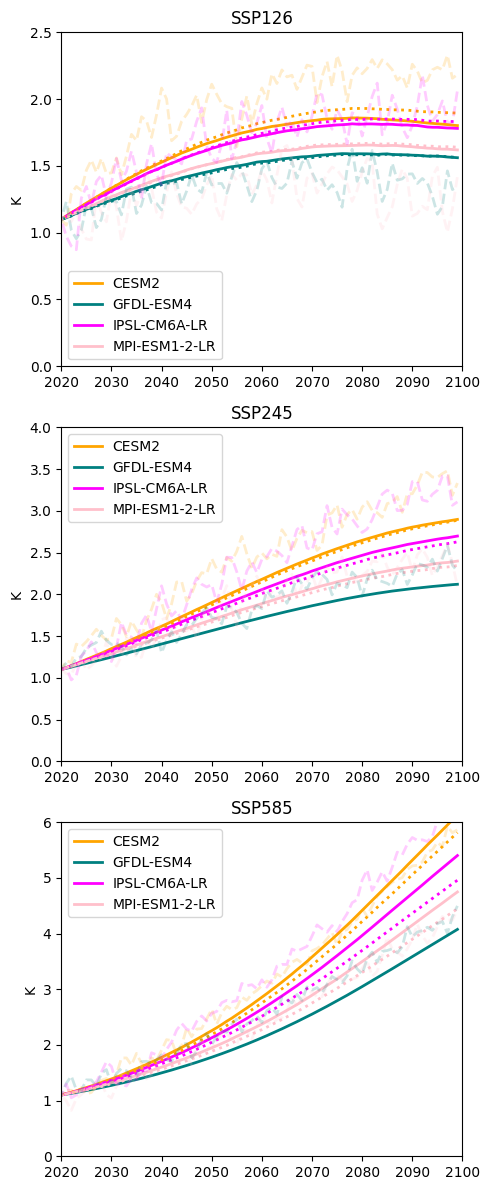

In [ ]:
from cycler import cycler

default_cycler = cycler(color=['orange', 'teal', 'magenta', 'pink'])
plt.rc('lines', linewidth=2)


fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(5,12))
ax[0].set_prop_cycle(default_cycler)
p1=ax[0].plot(np.arange(1850,2100),1.1+(cumemis_unfccc[:250,:,0]-cumemis_unfccc[170,:,0])/1000*tcre_un[f_in])
ax[0].plot(np.arange(1850,2100),1.1+(cumemis[:250,:,0]-cumemis[170,:,0])/1000*tcre[f_in],':')
ax[0].plot(np.arange(1850,2100),1.1+tas_ttl[:250,:,0]-tas_ttl[170,:,0],'--',alpha=0.2)
ax[0].set_title('SSP126')
ax[0].set_ylabel('K')
ax[0].set_ylim([0,2.5])
ax[0].set_xlim([2020,2100])
ax[0].legend(p1,mdl26)

ax[1].set_prop_cycle(default_cycler)
p1=ax[1].plot(np.arange(1850,2100),1.1+(cumemis_unfccc[:250,:,1]-cumemis_unfccc[170,:,1])/1000*tcre_un[f_in])
ax[1].plot(np.arange(1850,2100),1.1+(cumemis[:250,:,1]-cumemis[170,:,1])/1000*tcre[f_in],':')
ax[1].plot(np.arange(1850,2100),1.1+tas_ttl[:250,:,1]-tas_ttl[170,:,1],'--',alpha=0.2)
ax[1].set_title('SSP245')
ax[1].set_ylabel('K')
ax[1].set_ylim([0,4])
ax[1].set_xlim([2020,2100])
ax[1].legend(p1,mdl26)


ax[2].set_prop_cycle(default_cycler)
p1=ax[2].plot(np.arange(1850,2100),1.1+(cumemis_unfccc[:250,:,2]-cumemis_unfccc[170,:,2])/1000*tcre_un[f_in])
ax[2].plot(np.arange(1850,2100),1.1+(cumemis[:250,:,2]-cumemis[170,:,2])/1000*tcre[f_in],':')
ax[2].plot(np.arange(1850,2100),1.1+tas_ttl[:250,:,2]-tas_ttl[170,:,2],'--',alpha=0.2)
ax[2].set_title('SSP585')
ax[2].set_ylabel('K')
ax[2].set_ylim([0,6])
ax[2].set_xlim([2020,2100])
ax[2].legend(p1,mdl26)
ax[2].set_prop_cycle(default_cycler)

plt.tight_layout()


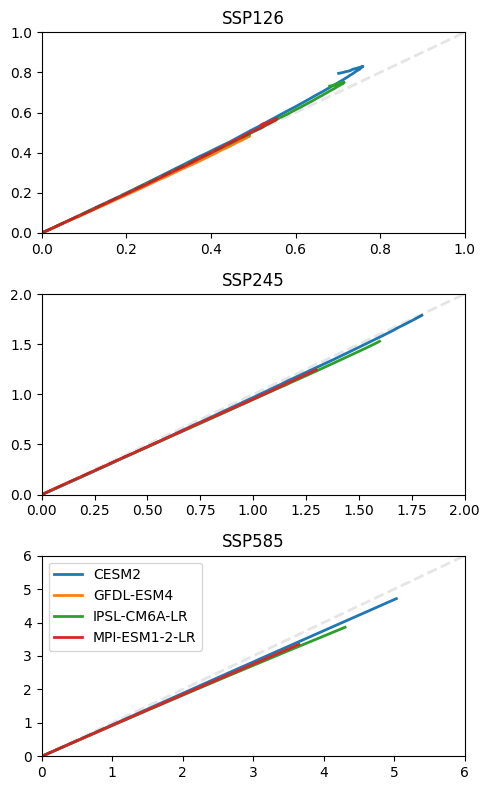

In [ ]:
from cycler import cycler

default_cycler = cycler(color=['orange', 'teal', 'magenta', 'pink'])
plt.rc('lines', linewidth=2)


fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(5,8))
ax[0].plot((cumemis_unfccc[:250,:,0]-cumemis_unfccc[bsyr,:,0])/1000*tcre_un[f_in],(cumemis[:250,:,0]-cumemis[bsyr,:,0])/1000*tcre[f_in])
ax[0].plot([0,6],[0,6],'k--',alpha=0.1)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].set_title('SSP126')

ax[1].plot((cumemis_unfccc[:250,:,1]-cumemis_unfccc[bsyr,:,1])/1000*tcre_un[f_in],(cumemis[:250,:,1]-cumemis[bsyr,:,1])/1000*tcre[f_in])
ax[1].plot([0,6],[0,6],'k--',alpha=0.1)
ax[1].set_xlim([0,2])
ax[1].set_ylim([0,2])
ax[1].set_title('SSP245')

p1=ax[2].plot((cumemis_unfccc[:250,:,2]-cumemis_unfccc[bsyr,:,2])/1000*tcre_un[f_in],(cumemis[:250,:,2]-cumemis[bsyr,:,2])/1000*tcre[f_in])
ax[2].plot([0,6],[0,6],'k--',alpha=0.1)
ax[2].set_xlim([0,6])
ax[2].set_ylim([0,6])
ax[2].set_title('SSP585')

ax[2].legend(p1,mdl26)
plt.tight_layout()


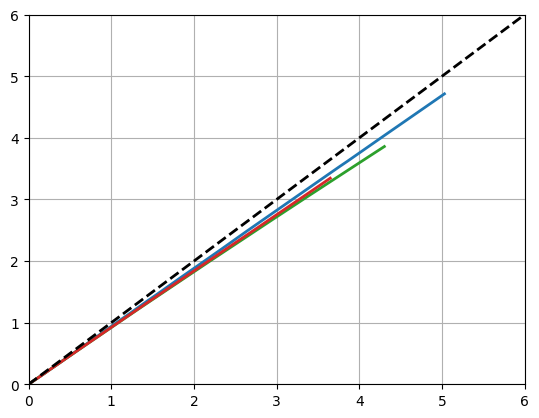

In [ ]:
#ssp585

plt.plot((cumemis_unfccc[:250,:,2]-cumemis_unfccc[bsyr,:,2])/1000*tcre_un[f_in],(cumemis[:250,:,2]-cumemis[bsyr,:,2])/1000*tcre[f_in])
plt.plot([0,6],[0,6],'k--')
plt.xlim([0,6])
plt.ylim([0,6])

plt.grid()

In [ ]:
dy_conc['ssp126'][0]

<xarray.Dataset>
Dimensions:       (lat: 192, year: 252, nbnd: 2, lon: 288)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds      (year, lat, nbnd) float64 -90.0 -89.53 -89.53 ... 89.53 90.0
  * lon           (lon) float64 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
    lon_bnds      (lon, nbnd) float32 179.4 180.6 180.6 ... 178.1 178.1 179.4
  * year          (year) int64 1850 1851 1852 1853 1854 ... 2098 2099 2100 2101
    spatial_ref   int64 0
Dimensions without coordinates: nbnd
Data variables: (12/18)
    tas           (year, lat, lon) float32 224.1 224.1 224.1 ... nan nan nan
    fgco2         (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cVeg          (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cSoil         (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cLitter       (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cProduct      (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    ...            ...
    cLand_dist    (year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cSlVg_dist    (year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    distfrac      (year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cLandn_d      (year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cLandn        (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cOcn_d        (year, lat, lon) float32 0.0 0.0 0.0 ... 0.3285 0.3285 0.3285

In [ ]:
url = 'https://www.geoboundaries.org/data/1_3_3/zip/shapefile/NOR/NOR_ADM0.shp.zip'
norway_shapefile = gpd.read_file(url)

In [ ]:
def get_cgrids(ds,cnt):
  gdf = gpd.read_file('https://www.geoboundaries.org/data/1_3_3/zip/shapefile/'+cnt+'/'+cnt+'_ADM0.shp.zip')

  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
  gdf_crs=gdf.translate(xoff=360)
  gdf["exists"] = 1

  out_grid=make_geocube(vector_data=gdf, measurements=["exists"], fill=np.nan, resolution=(0.05, -0.05)).fillna(0)

  out_grid=out_grid.rename({'x': 'lon','y': 'lat'})

  upsampled = out_grid.interp_like(ds)
  upsampled['intfrac']=upsampled['exists'].fillna(0)
  return upsampled


In [ ]:
da=dy_conc['ssp126'][0]
tmp=get_cgrids(da,'NOR')

<ipython-input-119-8c684c8f3b10>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


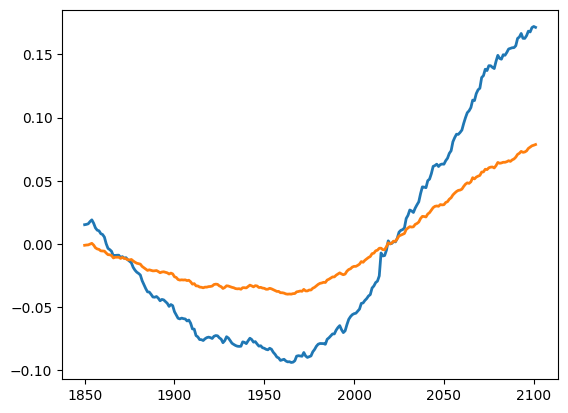

In [ ]:
cland_nor=(dy_conc['ssp126'][0]['cLand']*tmp['exists']).mean('lat').mean('lon')
plt.plot(cland_nor['year'],cland_nor-cland_nor[bsyr])

cland_dis=(dy_conc['ssp126'][0]['cLand_dist']*tmp['exists']).mean('lat').mean('lon')
plt.plot(cland_nor['year'],cland_dis-cland_dis[bsyr])



In [ ]:
glb_nor= np.ones((500,len(mdl26),len(scns)))*np.nan
glb_nordis= np.ones((500,len(mdl26),len(scns)))*np.nan
ocn_nor= np.ones((500,len(mdl26),len(scns)))*np.nan
#atm_ttl= np.ones((500,len(mdl26),len(scns)))*np.nan
prd_nor= np.ones((500,len(mdl26),len(scns)))*np.nan
hrv_nor= np.ones((500,len(mdl26),len(scns)))*np.nan
lit_nor= np.ones((500,len(mdl26),len(scns)))*np.nan

tas_nor= np.ones((500,len(mdl26),len(scns)))*np.nan
for j,s in enumerate(scns):
    for i,m in enumerate(mdl26):
        co2atm=278*1.01**np.arange(0,len(dy_conc[s][i]['year']))
        (glb_ttl_tmp,glb_dis_tmp,ocn_ttl_tmp,atm_ttl_tmp,tas_tmp,prd_tmp,hrv_tmp,lit_tmp)=get_gflx(dy_conc[s][i],co2atm)
        glb_nor[:len(glb_ttl_tmp),i,j]=glb_ttl_tmp
        glb_nordis[:len(glb_ttl_tmp),i,j]=glb_dis_tmp
        ocn_nor[:len(glb_ttl_tmp),i,j]=ocn_ttl_tmp
#        atm_ttl[:len(glb_ttl_tmp),i,j]=atm_ttl_tmp
        prd_nor[:len(glb_ttl_tmp),i,j]=prd_tmp
        hrv_nor[:len(glb_ttl_tmp),i,j]=hrv_tmp
        lit_nor[:len(glb_ttl_tmp),i,j]=lit_tmp
        tas_nor[:len(glb_ttl_tmp),i,j]=tas_tmp


In [ ]:
mdl26[1]

'GFDL-ESM4'

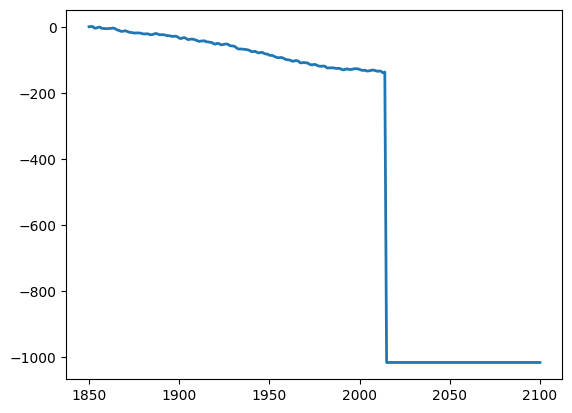

In [ ]:
plt.plot(cland_nor['year'],glb_nor[:252,1,1])

In [ ]:
dy_conc['ssp126'][0]

<xarray.Dataset>
Dimensions:       (lat: 192, year: 252, nbnd: 2, lon: 288)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds      (year, lat, nbnd) float64 -90.0 -89.53 -89.53 ... 89.53 90.0
  * lon           (lon) float64 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
    lon_bnds      (lon, nbnd) float32 179.4 180.6 180.6 ... 178.1 178.1 179.4
  * year          (year) int64 1850 1851 1852 1853 1854 ... 2098 2099 2100 2101
    spatial_ref   int64 0
Dimensions without coordinates: nbnd
Data variables: (12/18)
    tas           (year, lat, lon) float32 224.1 224.1 224.1 ... nan nan nan
    fgco2         (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cVeg          (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cSoil         (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cLitter       (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cProduct      (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    ...            ...
    cLand_dist    (year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cSlVg_dist    (year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    distfrac      (year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cLandn_d      (year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cLandn        (year, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cOcn_d        (year, lat, lon) float32 0.0 0.0 0.0 ... 0.3285 0.3285 0.3285